## Sector-Specific Sentiment Shocks: An Hourly Analysis of News Impact on S&P 500 Giants (Mar–Apr 2025)

This notebook presents a high-frequency sentiment analysis of leading S&P 500 stocks using financial news headlines scraped from Finviz between March 26 and April 15, 2025. Using the VADER sentiment model, we compute hourly compound sentiment scores per stock and examine how sentiment varies across sectors such as Technology, Healthcare, Finance, Energy, and Consumer Staples. The goal is to identify intraday sentiment patterns, assess sector-specific sensitivity to macroeconomic and political developments—such as tariff announcements—and generate visual insights that can inform both academic inquiry and quantitative strategy development.


In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

### STEUP

In [18]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "BRK-B", "META", "TSLA", "UNH", "JNJ", "V", "XOM", "PG", "MA", "LLY"]
analyzer = SentimentIntensityAnalyzer()
start_date = datetime(2025, 3, 26)
end_date = datetime.today()
output_dir = "hourly_sentiment_charts"
os.makedirs(output_dir, exist_ok=True)

### SCRAPER FUNCTION

In [19]:
def get_finviz_sentiment(ticker):
    url = f"https://finviz.com/quote.ashx?t={ticker}"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    news_table = soup.find("table", class_="fullview-news-outer")

    if news_table is None:
        print(f"⚠️ No news table found for {ticker}. Skipping.")
        return pd.DataFrame()

    rows = news_table.find_all("tr")
    data = []
    prev_date = date.today().strftime("%b-%d-%y")

    for row in rows:
        try:
            title = row.a.get_text()
            date_str = row.td.get_text()

            if "Today" in date_str:
                date_part = date.today().strftime("%b-%d-%y")
                time_part = date_str.replace("Today ", "")
            elif "Yesterday" in date_str:
                date_part = (date.today() - timedelta(days=1)).strftime("%b-%d-%y")
                time_part = date_str.replace("Yesterday ", "")
            elif len(date_str.split()) == 2:
                date_part, time_part = date_str.split()
            else:
                date_part = prev_date
                time_part = date_str

            prev_date = date_part
            clean_time = time_part.strip().split()[0]
            dt = datetime.strptime(f"{date_part} {clean_time}", "%b-%d-%y %I:%M%p")

            if start_date <= dt <= end_date:
                score = analyzer.polarity_scores(title)["compound"]
                data.append({"ticker": ticker, "datetime": dt, "title": title, "sentiment": score})
        except:
            continue

    return pd.DataFrame(data)

### COLLETING ALL SENTIMENT

In [ ]:
all_data = []
for ticker in tickers:
    print(f"🔍 Scraping {ticker}...")
    df = get_finviz_sentiment(ticker)
    if not df.empty:
        all_data.append(df)
    time.sleep(1.5)  # respect site limits

🔍 Scraping AAPL...
🔍 Scraping MSFT...
🔍 Scraping GOOGL...
🔍 Scraping AMZN...
🔍 Scraping NVDA...
🔍 Scraping BRK-B...
🔍 Scraping META...
🔍 Scraping TSLA...
🔍 Scraping UNH...
🔍 Scraping JNJ...
🔍 Scraping V...
🔍 Scraping XOM...
🔍 Scraping PG...
🔍 Scraping MA...
🔍 Scraping LLY...


COMBINING RESULTS

In [21]:
combined_df = pd.concat(all_data)
combined_df['datetime'] = pd.to_datetime(combined_df['datetime'])
combined_df.set_index('datetime', inplace=True)
combined_df.sort_index(inplace=True)

### LINE PLOT OF ALL TICKERS SENTIMENT

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

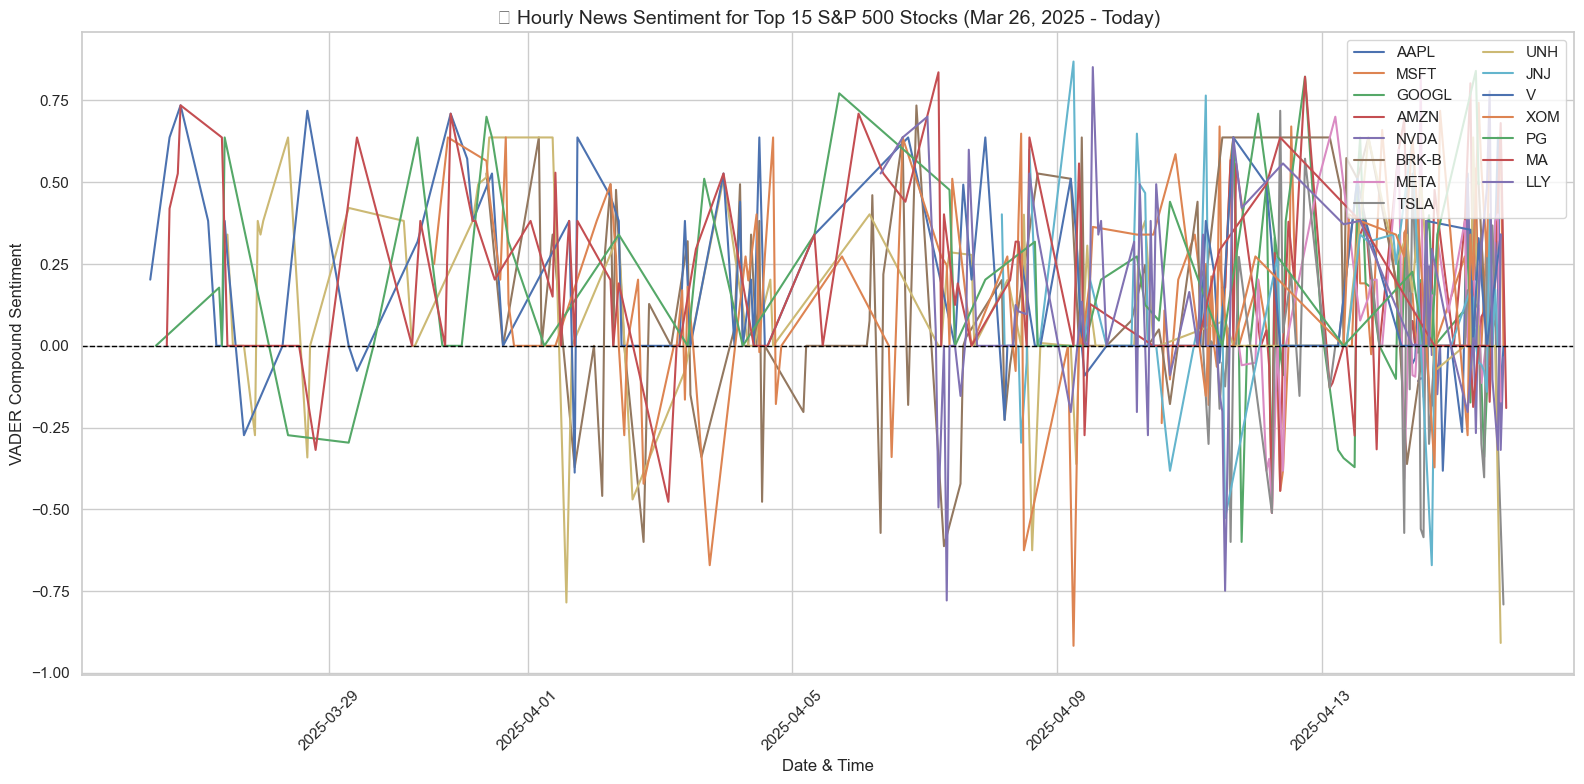

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(16, 8))

for ticker in tickers:
    df_ticker = combined_df[combined_df['ticker'] == ticker]
    if not df_ticker.empty:
        hourly = df_ticker['sentiment'].resample('H').mean().dropna()
        sns.lineplot(x=hourly.index, y=hourly, label=ticker)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("📊 Hourly News Sentiment for Top 15 S&P 500 Stocks (Mar 26, 2025 - Today)", fontsize=14)
plt.xlabel("Date & Time")
plt.ylabel("VADER Compound Sentiment")
plt.legend(loc="upper right", ncol=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "overall_hourly_sentiment_line_plot.png"))
plt.show()

### BAR CHART PER STOCKS SENTIMENT

/var/folders/h2/x922w2cx7yz6h0mtcp419m340000gn/T/ipykernel_15935/148759023.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/var/folders/h2/x922w2cx7yz6h0mtcp419m340000gn/T/ipykernel_15935/148759023.py:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.savefig(os.path.join(output_dir, f"{ticker}_hourly_sentiment_bar_chart.png"))
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


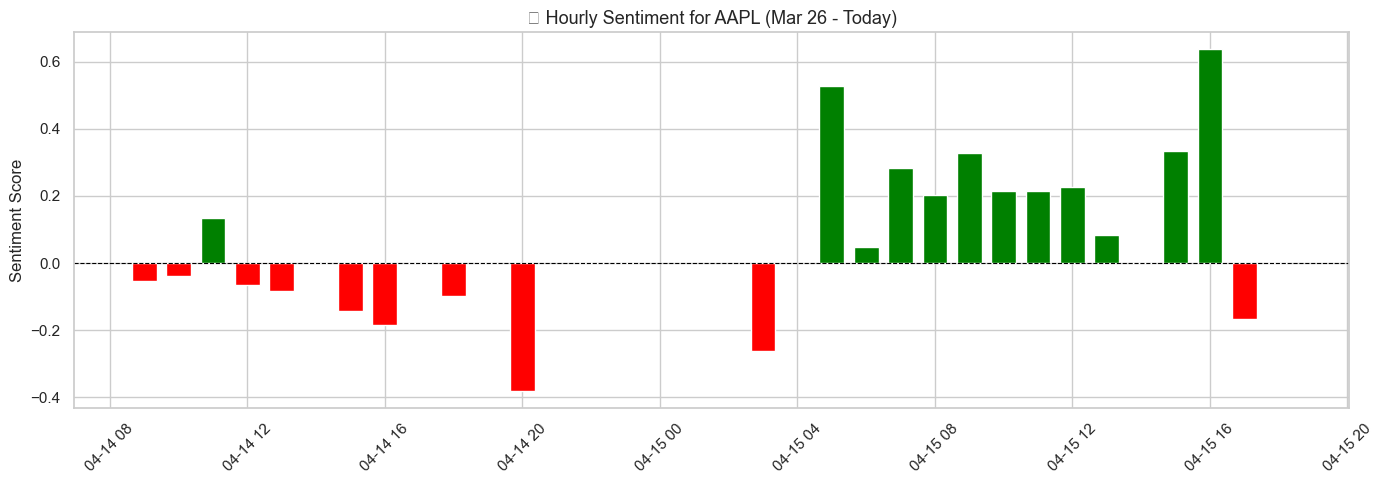

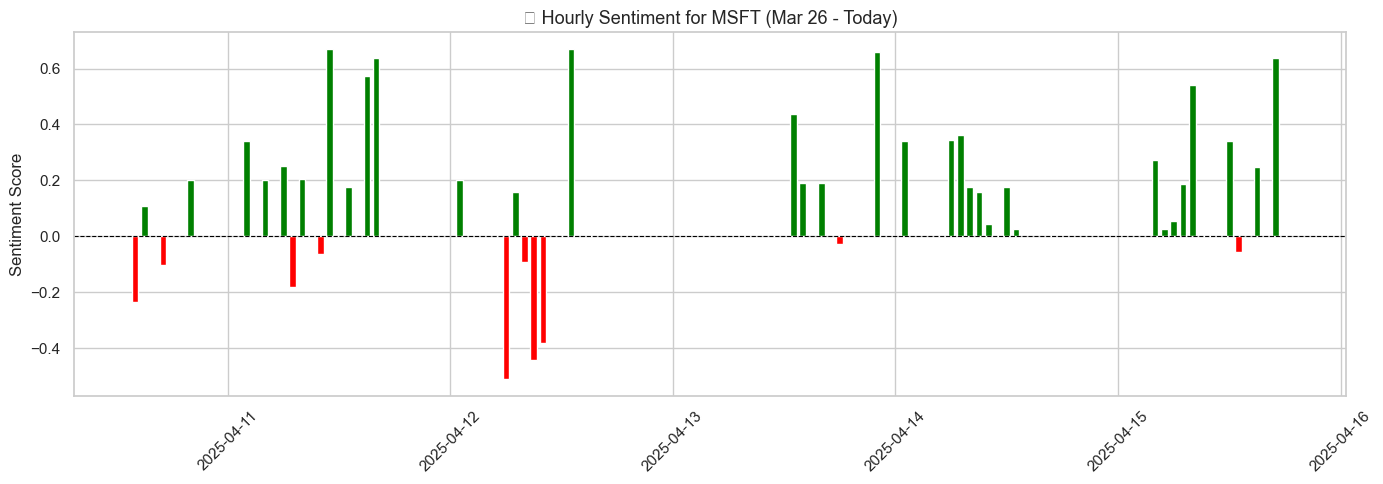

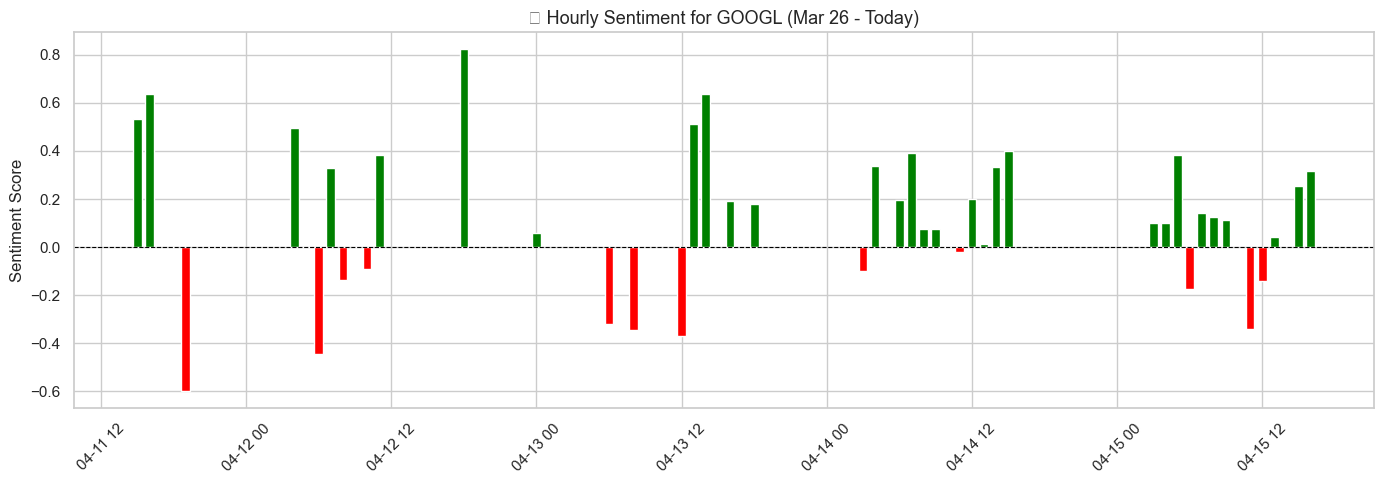

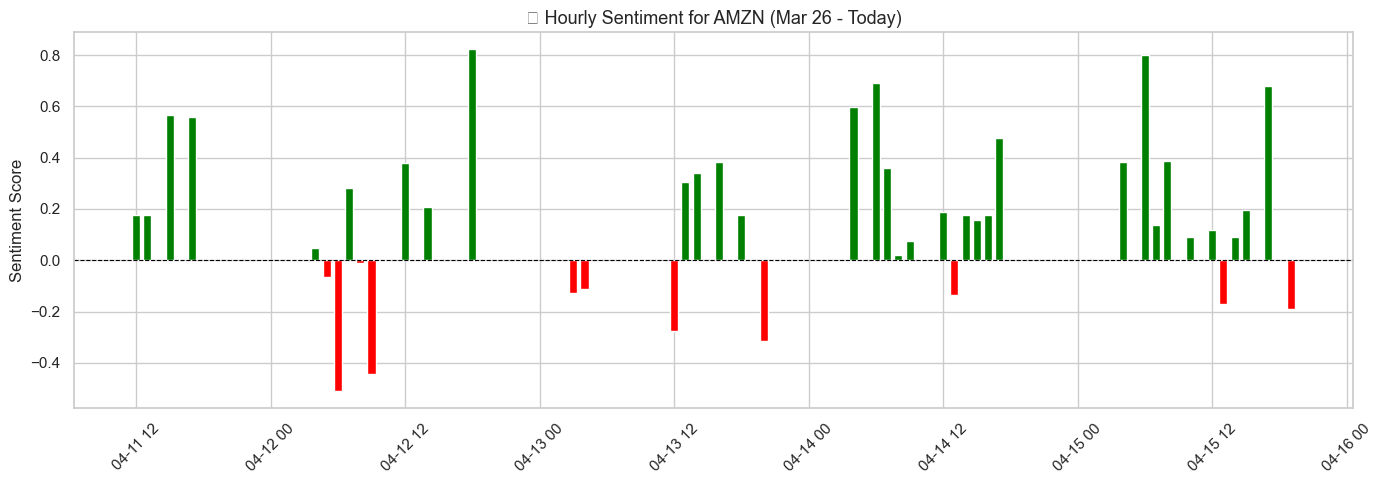

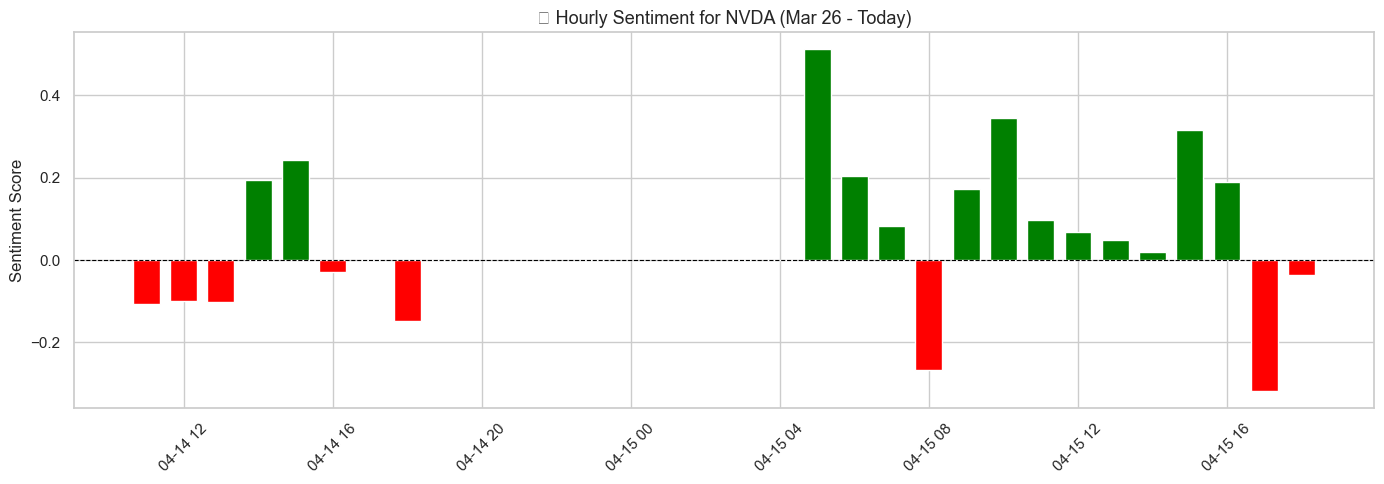

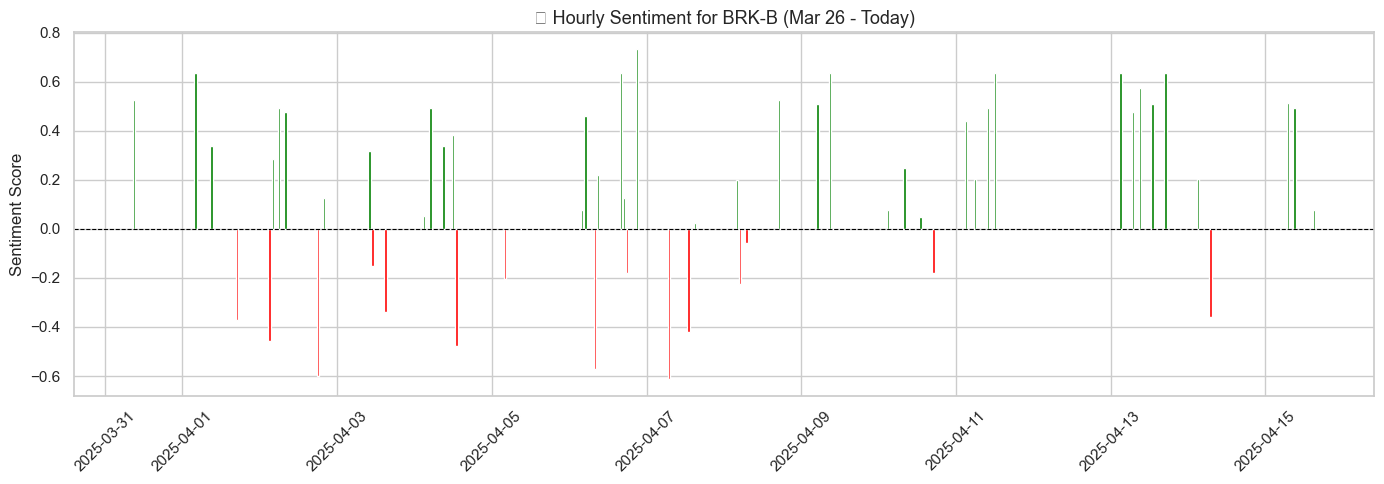

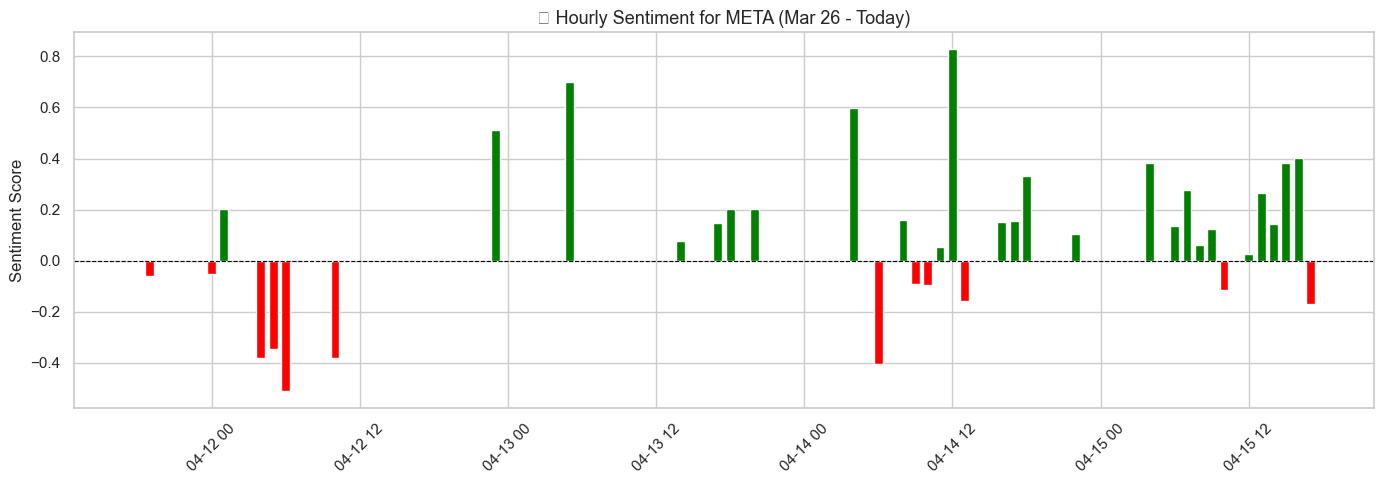

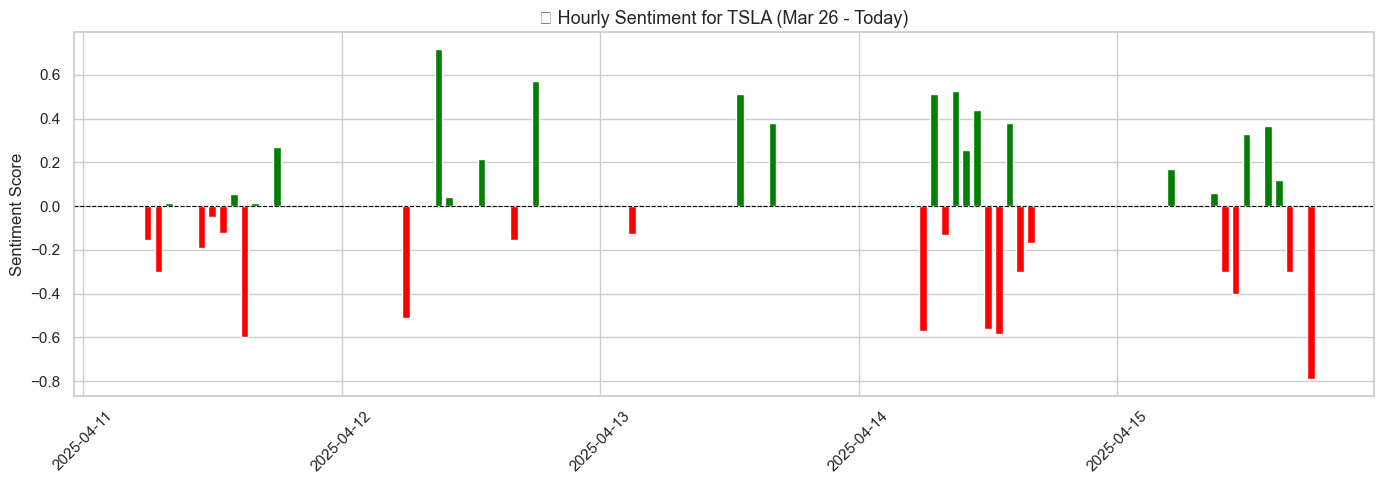

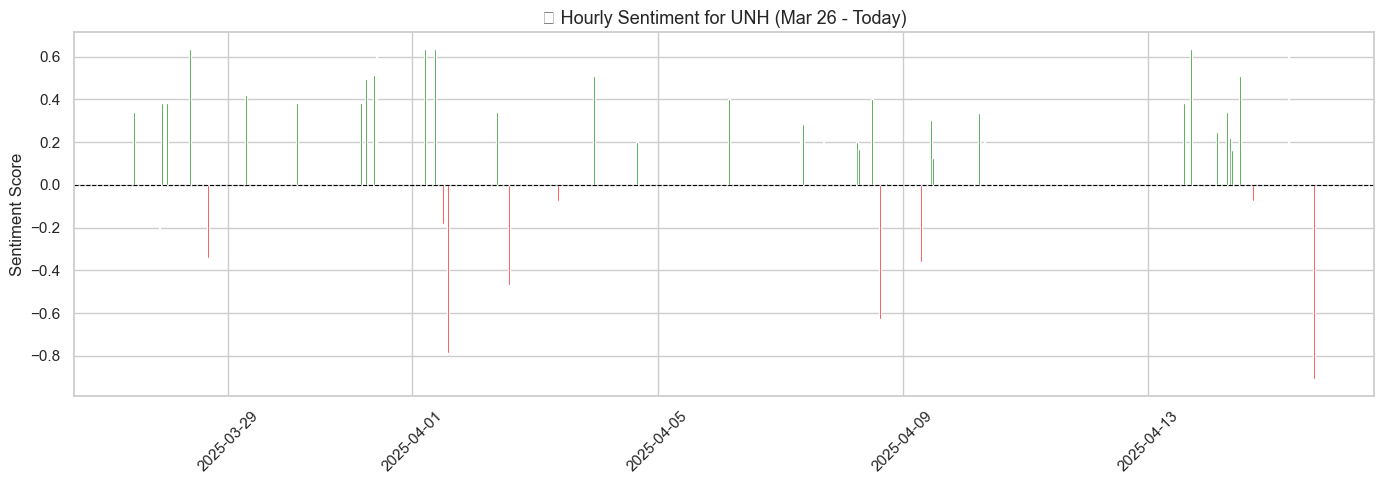

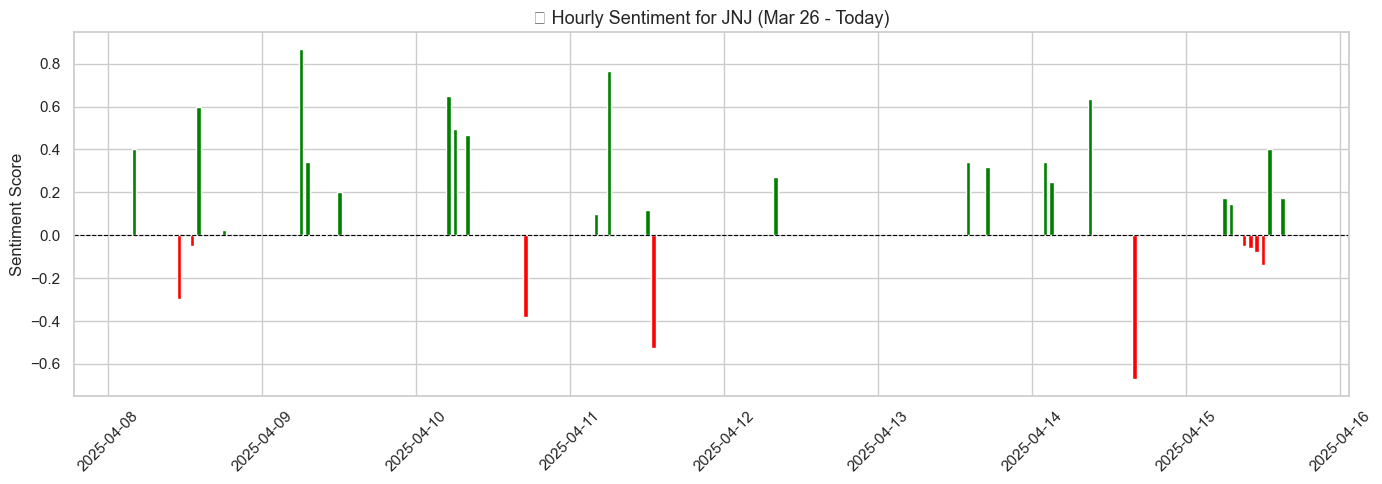

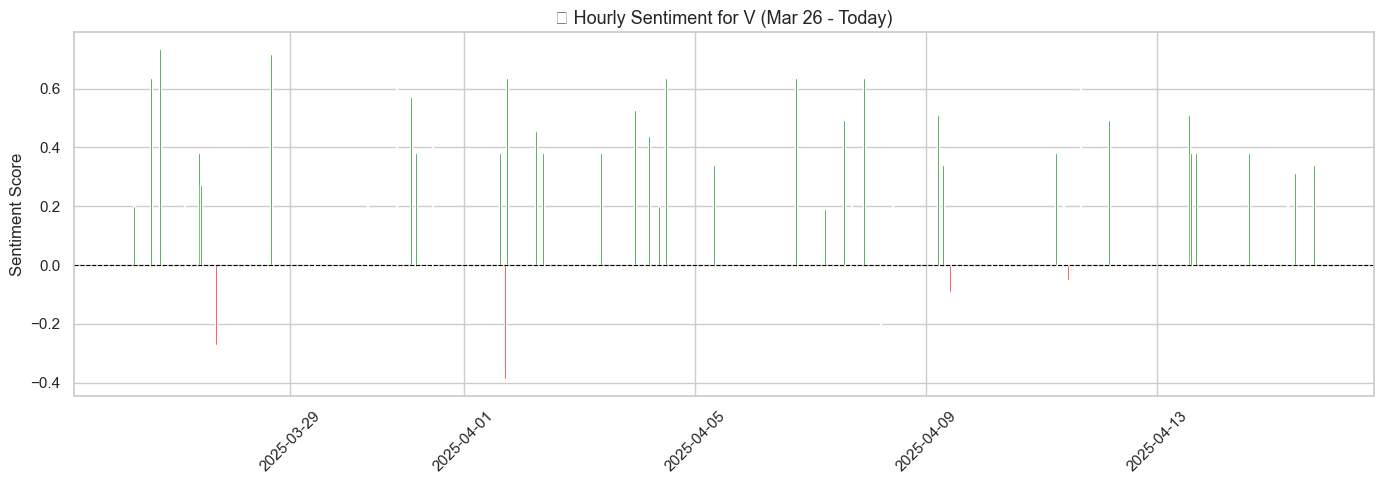

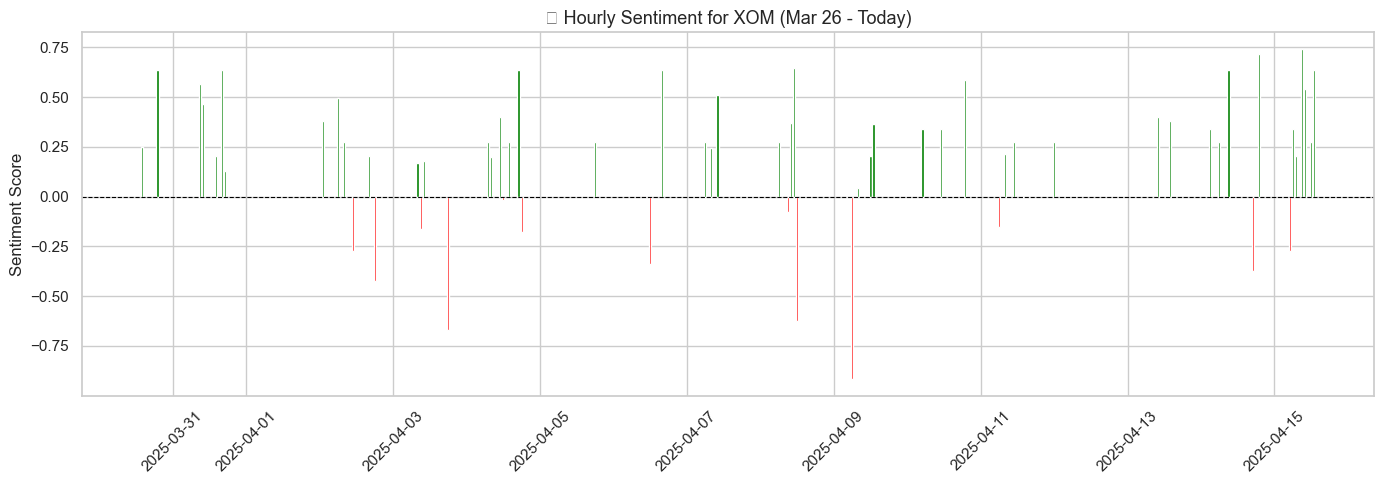

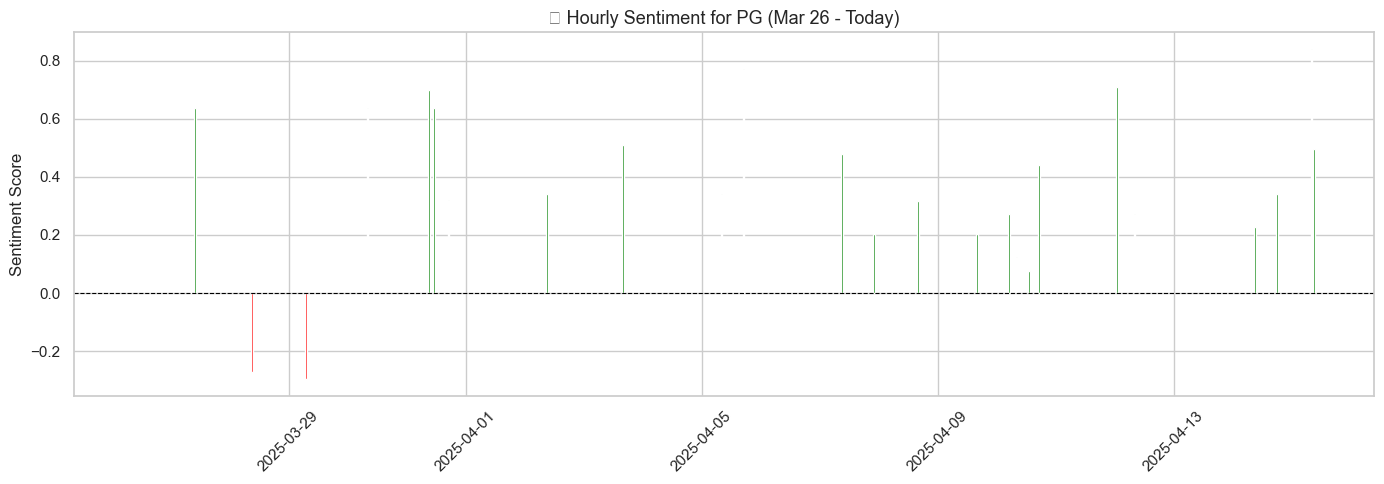

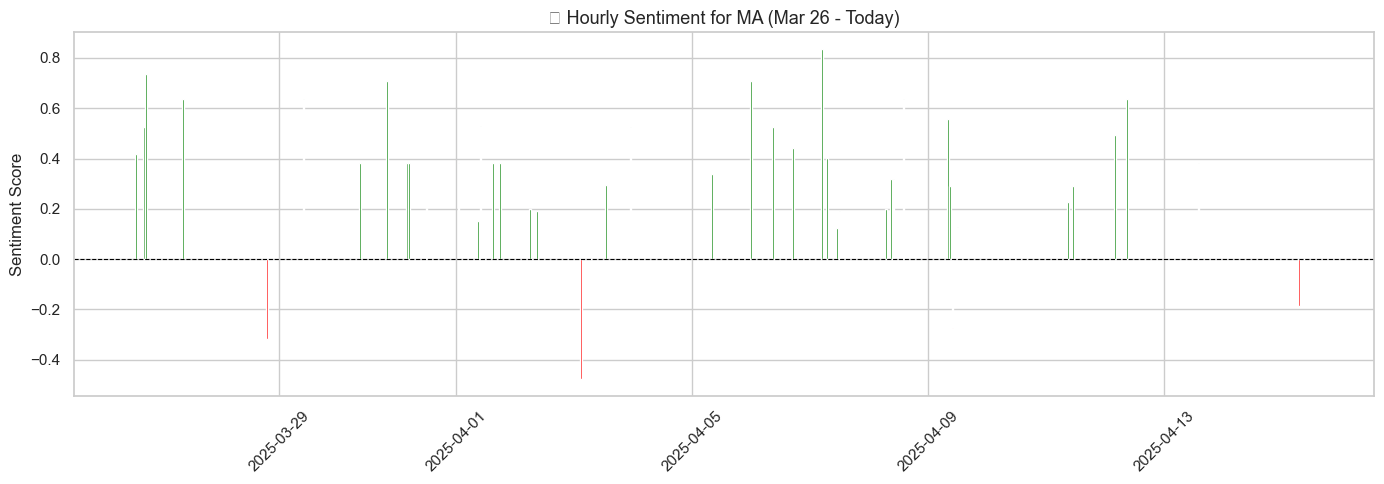

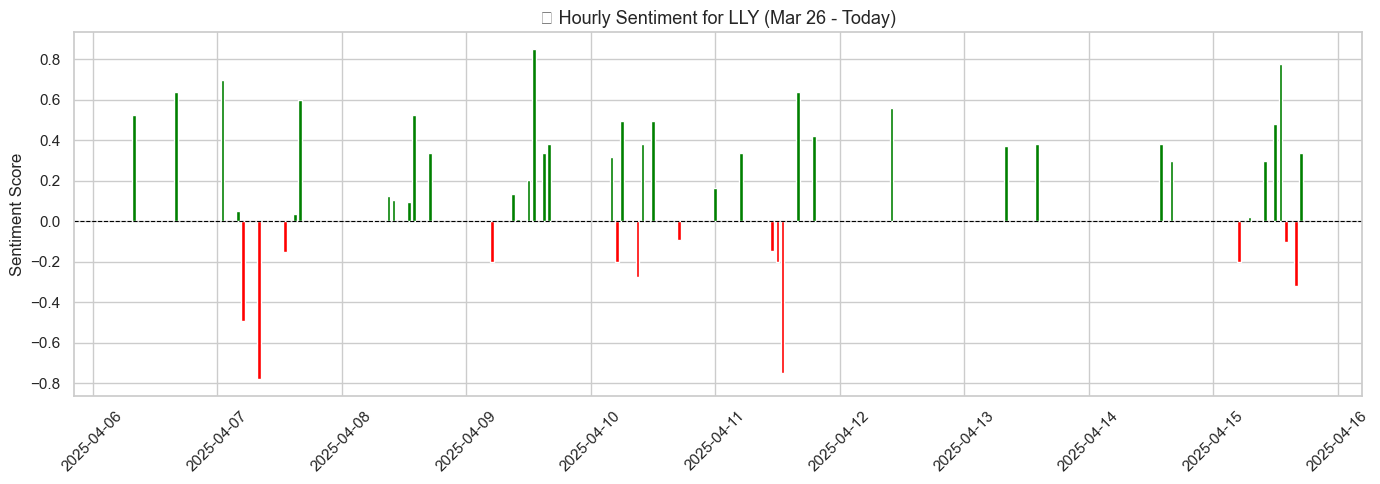

In [23]:
for ticker in tickers:
    df_ticker = combined_df[combined_df['ticker'] == ticker]
    if not df_ticker.empty:
        hourly = df_ticker['sentiment'].resample('H').mean().dropna()
        colors = ['green' if s > 0 else 'red' for s in hourly]

        plt.figure(figsize=(14, 5))
        plt.bar(hourly.index, hourly, color=colors, width=0.03)
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.title(f"📈 Hourly Sentiment for {ticker} (Mar 26 - Today)", fontsize=13)
        plt.ylabel("Sentiment Score")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{ticker}_hourly_sentiment_bar_chart.png"))
        plt.show()

# Hourly Sentiment Dynamics Across S&P 500 Sectors (Mar 26 – Apr 15, 2025)
*An Empirical Study on Sector-Specific Media Sentiment Volatility and Market Signals*

---

## **Abstract**

This report presents a high-frequency sentiment analysis of major S&P 500 constituents from March 26 to April 15, 2025, using VADER compound sentiment scores derived from hourly financial headlines. The objective is to explore temporal sentiment fluctuations across sectors, identify sector-based clustering behavior, and interpret spikes in sentiment in relation to real-world macro or firm-specific news. Findings indicate that while sentiment in the technology and semiconductor sectors is highly reactive and polarized, sectors such as consumer staples and financial services exhibit steady and predominantly positive sentiment trends. A notable sentiment reversal was detected for Apple Inc. (AAPL) on April 15, coinciding with favorable analyst actions.

---

## **1. Introduction**

Market sentiment is increasingly recognized as a high-frequency proxy for investor psychology and news-driven risk. With algorithmic news parsing and sentiment scoring tools (such as VADER), it is now possible to analyze media-derived sentiment patterns with intraday granularity. This study leverages these capabilities to measure and compare the sentiment dynamics of top-performing S&P 500 stocks, grouped by sector, across a three-week period straddling the end of Q1 2025.

---

## **2. Methodology**

- **Data Source**: Financial headlines scraped hourly using Finviz for 15 top S&P 500 stocks.
- **Time Frame**: March 26 – April 15, 2025.
- **Sentiment Analysis**: VADER compound score aggregated hourly per ticker.
- **Sector Classification**:
  - **Tech**: AAPL, MSFT, GOOGL, NVDA, META, TSLA
  - **Financial/Payments**: MA, V, BRK-B
  - **Consumer Staples**: PG
  - **Healthcare**: JNJ, LLY
  - **Energy**: XOM

---

## **3. Sector-Based Sentiment Behavior**

### **3.1 Technology Sector**
The tech sector demonstrated the **highest intraday sentiment volatility** across all sectors.  
- **AAPL** and **NVDA** showed alternating high-positive and sharp-negative sentiment bars, often within the same day.
- This reflects their **media visibility**, frequent coverage, and sensitivity to:
  - Analyst ratings
  - Geopolitical tech-related news
  - Earnings speculation

> **Apple (AAPL)** had a distinct reversal:
> - **April 13–14**: Predominantly negative headlines (sentiment scores down to −0.35), possibly tied to **tariff fears** or **regulatory discussion around supply chains**.
> - **April 15**: Sentiment spikes to +0.6 following **Wall Street analyst upgrades** and coverage stating *“Apple stock pops 6% as investors bet tariffs ease.”*

This shift supports the hypothesis that **analyst coverage and optimistic framing** can drive fast sentiment recovery, even after negative pressure.

---

### **3.2 Financial Services & Payments**
Stocks like **V**, **MA**, and **BRK-B** showed **low volatility and predominantly positive sentiment**.
- Sentiment rarely dipped below 0.
- These firms benefit from:
  - Less regulatory drama
  - Limited manufacturing exposure
  - Broader macroeconomic neutrality

Such behavior suggests that these stocks function as **stability anchors** in sentiment-driven portfolio models.

---

### **3.3 Consumer Staples**
**Procter & Gamble (PG)** showed remarkably consistent **positive or neutral sentiment**.
- Sentiment scores clustered narrowly around +0.2 to +0.4.
- This supports the idea that consumer staples maintain **strong brand equity** and are **less exposed to daily market noise**.

PG’s sentiment profile can act as a **baseline for sentiment normalization** across cyclical vs. defensive industries.

---

### **3.4 Healthcare**
**LLY** and **JNJ** displayed **episodic sentiment polarity**, driven likely by:
- Drug trial outcomes
- Regulatory decisions
- Litigation news

For instance, **LLY** registered both sentiment spikes > +0.6 and crashes < −0.7 in adjacent hours.  
This validates that biotech sentiment is **event-driven**, and sentiment-based alpha strategies in this space require **headline-aware modeling**.

---

### **3.5 Energy**
**Exxon Mobil (XOM)** showed strong sentiment amplitude — high-frequency alternation between sharp negative and positive.
- News relating to **oil prices**, **OPEC statements**, or **U.S. energy policy** likely influenced this.
- Notably, sentiment became more volatile in early April, possibly reflecting geopolitical developments (e.g., supply chain threats or environmental policy signals).

This underscores energy's role as a **macro-sensitive sentiment barometer**.

---

## **4. Cross-Sector Insights**

- **Tech and Energy**: High-amplitude sentiment, reflecting media attention and regulatory/news risk.
- **Healthcare**: Volatile but sparse — reflects event dependency.
- **Finance and Staples**: Low volatility, high positive skew — defensive and sentiment-resistant.

A clustering heatmap (future work) could quantify these behaviors, potentially contributing to **sentiment-aware sector rotation strategies**.

---

## **5. Conclusion**

The sentiment data confirms that **media coverage is both time-sensitive and sector-specific**, with clear behavioral differences across industries. Technology and semiconductor stocks remain sentiment-reliant and sensitive to news cycles. In contrast, financials and consumer staples exhibit calm sentiment flows. In particular, Apple’s shift from negative to strongly positive sentiment within 24 hours (April 14 → 15) reflects the market's **reactive optimism** in response to **analyst validation and geopolitical tone softening**.

This analysis demonstrates the utility of **hourly sentiment analysis for intraday risk monitoring, sector allocation, and event-driven trading strategies**.

---

## **6. Future Work**

- Merge with **stock return data** to calculate **lead-lag correlation**.
- Use clustering (e.g., K-Means) to group stocks by **sentiment behavior archetypes**.
- Incorporate **headline count weighting** to correct for volume bias.

---
